In [62]:
import pandas as pd
import numpy as np
import json
import itertools
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import entropy, mannwhitneyu

In [63]:
users = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')
users = users.drop(columns=[
    'external_degree','pct_internal','pct_external',
    'z_internal','betweenness','internal_degree'
])

topics = pd.read_csv('../../src/nlp/topic_modeling/topic_data.csv')
echo_cambers = pd.read_csv('../../src/research_question/echo_chambers_results.csv')
sentiments = pd.read_csv('../../src/nlp/sentiment/sentiment_scores.csv')
community_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/community_topic_counts.csv')

echo_cambers = echo_cambers.drop(columns=['community_type'], errors='ignore')

community_info = users.merge(topics, left_on='id', right_on='author', how='inner').drop(columns=['id_x'])
global_info = community_info.merge(echo_cambers, on='community_id', how='inner', suffixes=('_user', '_echo'))

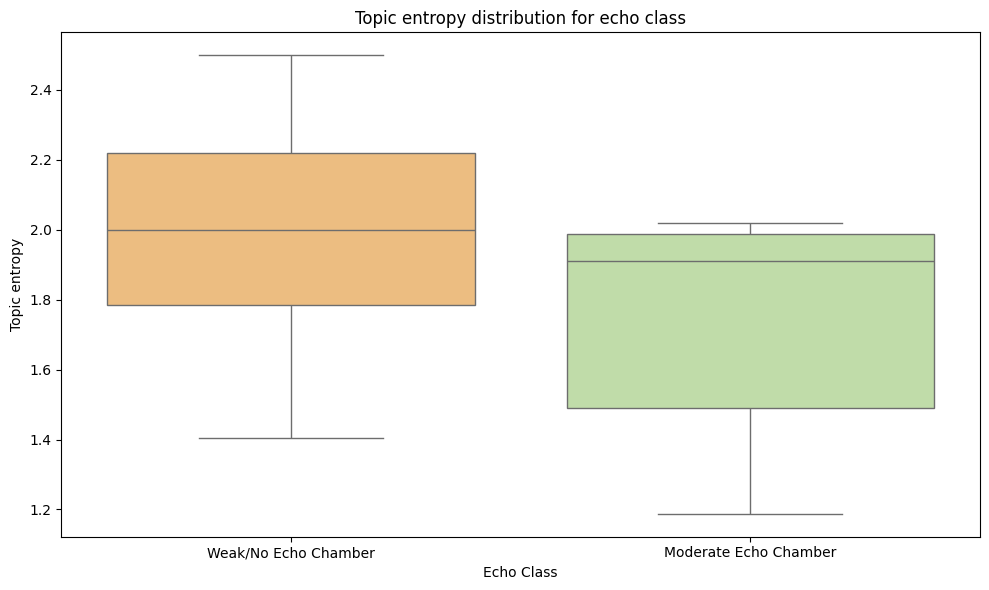

In [64]:
# Topic diversity in echo chambers - entropy
community_topic_counts_with_type = community_topic_counts.merge(
    global_info[['community_id', 'echo_class']].drop_duplicates(),
    on='community_id',
    how='left'
)

topic_diversity = community_topic_counts_with_type.groupby('community_id').agg({
    'count': lambda x: entropy(x/x.sum()),
    'echo_class': 'first'
}).reset_index().rename(columns={'count': 'topic_entropy'})


plt.figure(figsize=(10, 6))
sns.boxplot(data=topic_diversity, x='echo_class', hue='echo_class', y='topic_entropy', palette="Spectral")

counts = topic_diversity.groupby('echo_class')['community_id'].nunique()
for i, ct in enumerate(topic_diversity['echo_class'].unique()):
    n = counts.get(ct, 0)
plt.title("Topic entropy distribution for echo class")
plt.xlabel("Echo Class")
plt.ylabel("Topic entropy")
plt.tight_layout()
plt.show()

### Semantic Analysis

In [65]:
# Retrieving post by month
global_info['date'] = pd.to_datetime(global_info['date'], utc=True)
global_info['month'] = global_info['date'].dt.to_period('M').dt.to_timestamp()

/tmp/ipykernel_1638/309424242.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  global_info['month'] = global_info['date'].dt.to_period('M').dt.to_timestamp()


In [66]:
global_info = global_info.merge(sentiments, left_on='id_y', right_on='id', how='left' )

In [67]:
community_embeddings = np.load('../../src/nlp/community_embeddings.npy', allow_pickle=True)
user_embeddings = np.load('../../src/nlp/user_embeddings.npy', allow_pickle=True)

user_emb_dict = {uid: emb for uid, emb in user_embeddings}
community_emb_dict = {cid: emb for cid, emb in community_embeddings}

global_info['user_embedding'] = global_info['id'].map(user_emb_dict)
global_info['community_embedding'] = global_info['community_id'].map(community_emb_dict)
global_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230647 entries, 0 to 230646
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   degree               230647 non-null  int64              
 1   community_id         230647 non-null  int64              
 2   community_type       230647 non-null  object             
 3   is_hub               230647 non-null  bool               
 4   is_bridge            230647 non-null  bool               
 5   author_x             230647 non-null  object             
 6   id_y                 230647 non-null  object             
 7   type                 230647 non-null  object             
 8   date                 230647 non-null  datetime64[ns, UTC]
 9   lemmatized_text      230427 non-null  object             
 10  topic                230647 non-null  object             
 11  topic_id             230647 non-null  int64              
 12  nu

##### Semantic separation between echo and non-echo communities

In [68]:
sim_matrix = cosine_similarity(list(community_emb_dict.values()))

comm_distances = {}
for i, comm_id in enumerate(community_emb_dict.keys()):
    others = [j for j in range(len(community_emb_dict)) if j != i]
    comm_distances[comm_id] = 1 - np.mean(sim_matrix[i, others]) 
comm_distances = pd.Series(comm_distances, name="semantic_distance")

In [69]:
comm_info = global_info.groupby("community_id")["echo_class"].first()
results = pd.DataFrame({"echo_class": comm_info, "semantic_distance": comm_distances})
results.groupby("echo_class")["semantic_distance"].describe()


,count,mean,std,min,25%,50%,75%,max
echo_class,,,,,,,,
Moderate Echo Chamber,5.0,0.343955,0.037081,0.322028,0.325219,0.327577,0.335237,0.409711
Weak/No Echo Chamber,30.0,0.329182,0.062519,0.229978,0.299528,0.317067,0.365702,0.477863


In [70]:
sentiment_stats = global_info.groupby("community_id")[["neg_percentage","neu_percentage","pos_percentage"]].mean()
sentiment_var = global_info.groupby("community_id")[["neg_percentage","pos_percentage"]].std()

sentiment_summary = sentiment_stats.join(sentiment_var, rsuffix="_std")
sentiment_summary["echo_class"] = global_info.groupby("community_id")["echo_class"].first()

sentiment_summary["polarization"] = (sentiment_summary["pos_percentage"] - sentiment_summary["neg_percentage"]).abs()

sentiment_summary.groupby("echo_class")[["polarization","neg_percentage","pos_percentage"]].mean()


,polarization,neg_percentage,pos_percentage
echo_class,,,
Moderate Echo Chamber,0.363236,0.428013,0.064776
Weak/No Echo Chamber,0.286793,0.397049,0.110256


In [71]:
# Topic frequency per community
topic_counts = global_info.groupby(["community_id", "topic_id"]).size().reset_index(name="count")
topic_dist = topic_counts.groupby("community_id")["count"].apply(lambda x: x / x.sum())

# Computing entropy
topic_entropy = topic_dist.groupby("community_id").apply(lambda p: entropy(p, base=2))
topic_entropy = topic_entropy.rename("topic_entropy")

In [72]:
# Cosine similarity between communities
sim_matrix = cosine_similarity(list(community_emb_dict.values()))

# Distanza media di ogni community dalle altre
comm_distances = {}
for i, comm_id in enumerate(community_emb_dict.keys()):
    others = [j for j in range(len(community_emb_dict)) if j != i]
    comm_distances[comm_id] = 1 - np.mean(sim_matrix[i, others])
comm_distances = pd.Series(comm_distances, name="semantic_distance")

#### Sentiment Analysis

In [73]:
# Mean and variance for sentiments percentage
sentiment_stats = global_info.groupby("community_id")[["neg_percentage","neu_percentage","pos_percentage"]].mean()
sentiment_var   = global_info.groupby("community_id")[["neg_percentage","pos_percentage"]].std()

sentiment_summary = sentiment_stats.join(sentiment_var, rsuffix="_std")

# Sentiment polarization = abs diff between pos and neg
sentiment_summary["polarization"] = (sentiment_summary["pos_percentage"] - sentiment_summary["neg_percentage"]).abs()
comm_info = global_info.groupby("community_id")["echo_class"].first()

results = pd.concat([topic_entropy, comm_distances, sentiment_summary], axis=1)
results["echo_class"] = comm_info

corr_matrix = results[["topic_entropy","polarization","neg_percentage","pos_percentage"]].corr()

results.head()

,topic_entropy,semantic_distance,neg_percentage,neu_percentage,pos_percentage,neg_percentage_std,pos_percentage_std,polarization,echo_class
0,3.042389,0.334438,0.423190,0.506403,0.070407,0.370221,0.170889,0.352783,Weak/No Echo Chamber
1,3.605773,0.230380,0.343130,0.508105,0.148765,0.381520,0.271123,0.194365,Weak/No Echo Chamber
2,2.913055,0.325219,0.416333,0.492952,0.090715,0.386355,0.210411,0.325618,Moderate Echo Chamber
3,2.151722,0.335237,0.459748,0.477610,0.062642,0.372418,0.157250,0.397107,Moderate Echo Chamber
4,3.057185,0.365876,0.313852,0.464210,0.221938,0.372544,0.335944,0.091914,Weak/No Echo Chamber


In [74]:
print("Key correlations:")
print(corr_matrix)

Key correlations:
                topic_entropy  polarization  neg_percentage  pos_percentage
topic_entropy        1.000000     -0.113152        0.016366        0.296103
polarization        -0.113152      1.000000        0.934257       -0.799487
neg_percentage       0.016366      0.934257        1.000000       -0.532721
pos_percentage       0.296103     -0.799487       -0.532721        1.000000


In [75]:
# Comparative analysis: echo vs non-echo
group_comparison = results.groupby("echo_class")[["topic_entropy","semantic_distance","polarization"]].mean()
print(group_comparison)

                       topic_entropy  semantic_distance  polarization
echo_class                                                           
Moderate Echo Chamber       2.480614           0.343955      0.363236
Weak/No Echo Chamber        2.873021           0.329182      0.286793
